# Fine tunning Google vit-base-patch16-224-in21k with the top 51 categories of Google Landmark Dataset v2

### The top 51 categories correspond to the classes with more than 500 images

In [29]:
# Import libraries
import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from datasets import Dataset, Features, Image, load_dataset, load_metric
from sklearn.metrics import ConfusionMatrixDisplay, accuracy_score, confusion_matrix
from transformers import (
    Trainer,
    TrainingArguments,
    ViTFeatureExtractor,
    ViTForImageClassification,
)

%matplotlib inline

In [2]:
# Load dataset from huggingface
dataset_train, dataset_test = load_dataset(
    "pemujo/GLDv2_Top_51_Categories", split=["train", "test"]
)

Found cached dataset parquet (/home/jupyter/.cache/huggingface/datasets/pemujo___parquet/pemujo--GLDv2_Top_51_Categories-2b4a02f359c07f6b/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)


  0%|          | 0/2 [00:00<?, ?it/s]

In [3]:
dataset_train

Dataset({
    features: ['id', 'landmark_id', 'category', 'image', 'label'],
    num_rows: 36463
})

In [4]:
dataset_test

Dataset({
    features: ['id', 'landmark_id', 'category', 'image', 'label'],
    num_rows: 9116
})

In [5]:
# Import pre-trained ViT model from Hugginface
classes_count = len(set(dataset_train["label"]))
print("Classes count: ", classes_count)

model_id = "google/vit-base-patch16-224-in21k"

model = ViTForImageClassification.from_pretrained(
    model_id, num_labels=classes_count  # classification head
)

feature_extractor = ViTFeatureExtractor.from_pretrained(model_id)

display(model_id, classes_count)

Classes count:  51


Some weights of the model checkpoint at google/vit-base-patch16-224-in21k were not used when initializing ViTForImageClassification: ['pooler.dense.bias', 'pooler.dense.weight']
- This IS expected if you are initializing ViTForImageClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ViTForImageClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/jupyter/.local/lib/python3

'google/vit-base-patch16-224-in21k'

51

## Data Pre-Processing for Vision Transformers

In [6]:
def preprocess(batch):
    # take a list of PIL images and turn them to pixel values
    inputs = feature_extractor(batch["image"], return_tensors="pt")

    # include the labels
    inputs["label"] = batch["label"]
    return inputs


# transform the training dataset
prepared_train = dataset_train.with_transform(preprocess)

# And the testing dataset
prepared_test = dataset_test.with_transform(preprocess)

In [7]:
def collate_fn(batch):
    return {
        "pixel_values": torch.stack([x["pixel_values"] for x in batch]),
        "labels": torch.tensor([x["label"] for x in batch]),
    }


# accuracy metric
metric = load_metric("accuracy")


def compute_metrics(p):
    return metric.compute(
        predictions=np.argmax(p.predictions, axis=1), references=p.label_ids
    )

/var/tmp/ipykernel_1614/2881450272.py:8: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("accuracy")


In [8]:
# Assign to GPU if available
# device will determine whether to run the training on GPU or CPU.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

GPU_model = torch.cuda.get_device_name(0) if torch.cuda.is_available() else "cpu"
print(GPU_model)

model.to(device)

Tesla V100-SXM2-16GB


ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=7

In [12]:
# Training parameters and arguments

training_args = TrainingArguments(
    output_dir=f"./model_checkpoints_{GPU_model}",  # The output directory where the model predictions and checkpoints will be written.
    per_device_train_batch_size=16,  # per_device_train_batch_size (:obj:`int`, `optional`, defaults to 8): The batch size per GPU/TPU core/CPU for training.
    evaluation_strategy="steps",  # :obj:`"steps"`: Evaluation is done (and logged) every :obj:`eval_steps`.
    num_train_epochs=4,  # Use 4
    save_steps=3000,  # Number of updates steps before two checkpoint saves
    eval_steps=500,  # Number of updates between evaluation
    logging_steps=3000,  # Number of update steps between two logs.
    learning_rate=2e-4,  # learning_rate (:obj:`float`, `optional`, defaults to 5e-5):
    save_total_limit=2,
    remove_unused_columns=False,
    push_to_hub=False,
    load_best_model_at_end=True,
)

# Define trainer
trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    train_dataset=prepared_train,
    eval_dataset=prepared_test,
    tokenizer=feature_extractor,
)

# Train the Model

In [11]:
# Filepath to store model and checkpoints
filepath = f"./ViT_classifier_GLDv2_Top_51_Categories_{GPU_model}".replace(" ", "_")
filepath

'./ViT_classifier_GLDv2_Top_51_Categories_Tesla_V100-SXM2-16GB'

In [ ]:
t0 = time.time()
train_results = trainer.train()
t1 = time.time()
training_time = t1 - t0
print(f"Training time with {GPU_model} GPU: {training_time}")
# save tokenizer with the model
trainer.save_model(filepath)
trainer.log_metrics("train", train_results.metrics)
trainer.save_metrics("train", train_results.metrics)
# save the trainer state
trainer.save_state()

/home/jupyter/.local/lib/python3.9/site-packages/transformers/optimization.py:407: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss,Accuracy
500,No log,0.738635,0.819219
1000,No log,0.479338,0.866937
1500,No log,0.403280,0.885037
2000,No log,0.351331,0.901382
2500,No log,0.299493,0.914656
3000,0.549500,0.285615,0.922115
3500,0.549500,0.297146,0.920799
4000,0.549500,0.225339,0.939337
4500,0.549500,0.199345,0.942957


In [15]:
print(f"Training time with {GPU_model} GPU: {training_time/60} minutes")

Training time with Tesla V100-SXM2-16GB GPU: 68.05436414877573 minutes


# Model Evaluation
We can now evaluate our model using the accuracy metric defined above...

In [16]:
metrics = trainer.evaluate(prepared_test)
trainer.log_metrics("eval", metrics)
trainer.save_metrics("eval", metrics)
outputs = trainer.predict(prepared_test)

true_labels = outputs.label_ids
pred_labels = outputs.predictions.argmax(1)

***** eval metrics *****
  epoch                   =        4.0
  eval_accuracy           =     0.9741
  eval_loss               =     0.1156
  eval_runtime            = 0:01:19.09
  eval_samples_per_second =    115.255
  eval_steps_per_second   =     14.413


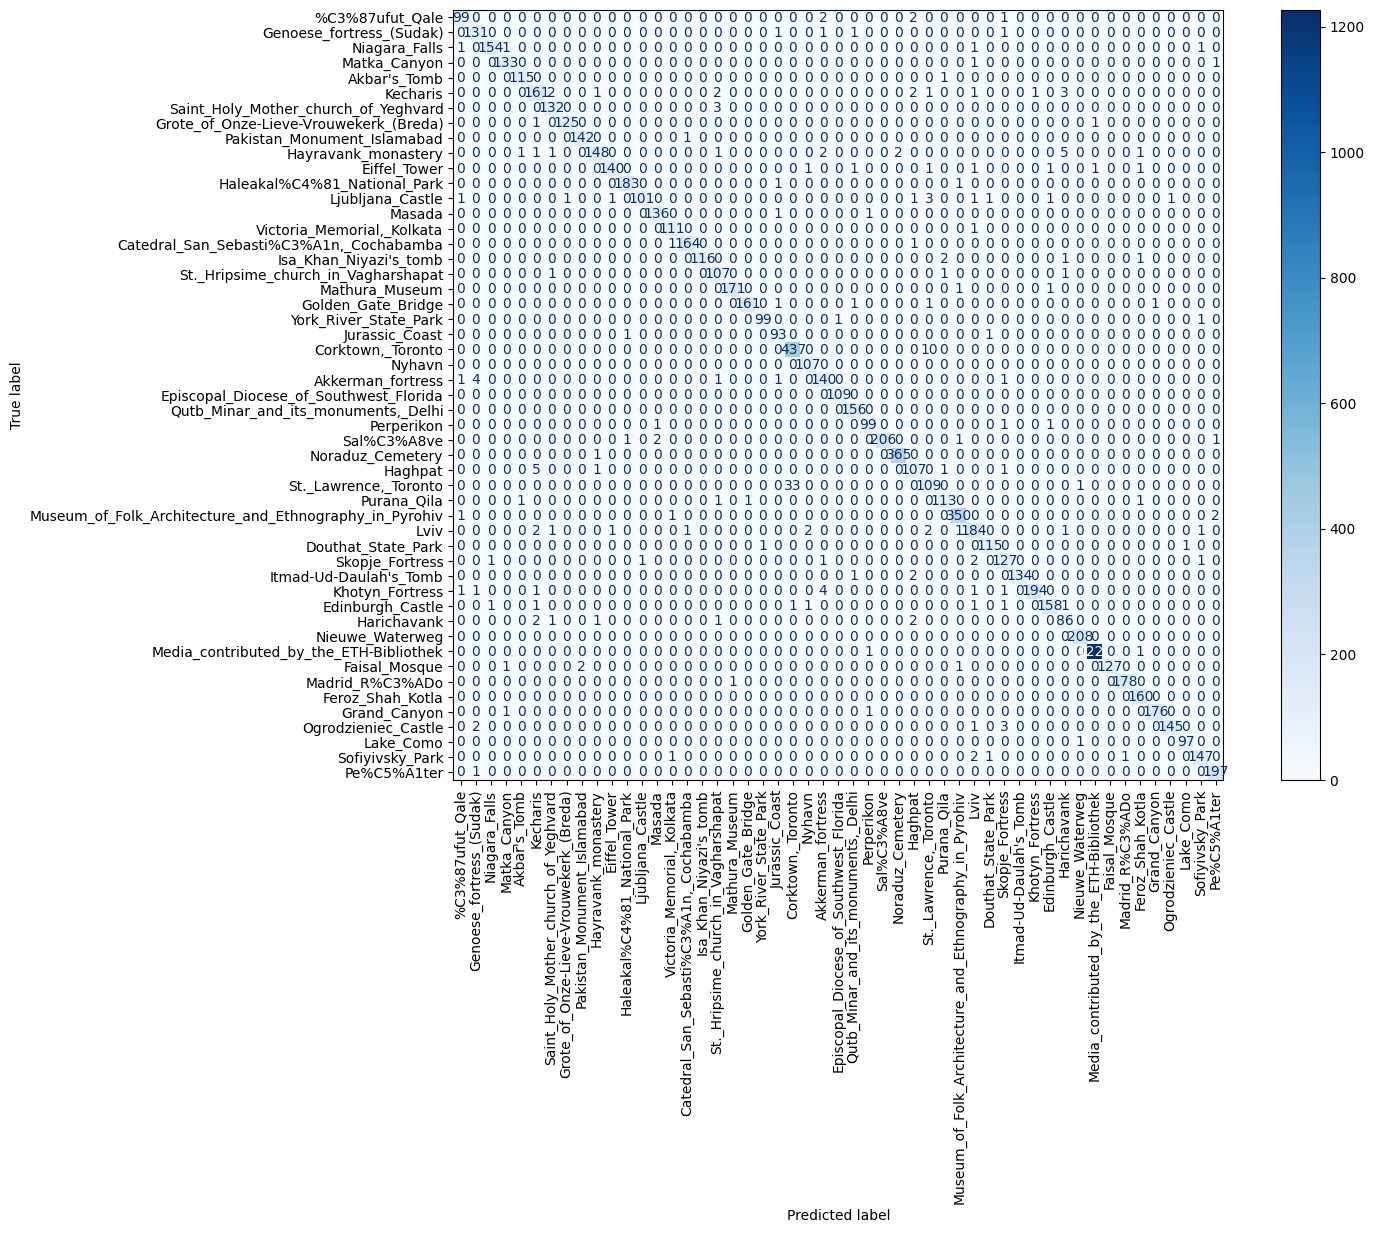

In [18]:
# Confusion matrix
cm_labels = list(
    dataset_test.to_pandas()[["label", "category"]]
    .groupby(["label", "category"])
    .all()
    .reset_index()
    .to_dict()["category"]
    .values()
)

cm = confusion_matrix(true_labels, pred_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=cm_labels)
disp.plot(xticks_rotation=90, cmap="Blues")

fig = disp.ax_.get_figure()
fig.set_figwidth(15)
fig.set_figheight(10)

In [31]:
# Load saved model
filepath = "./ViT_classifier_GLDv2_Top_51_Categories_Tesla_V100-SXM2-16GB/"
model_finetuned = ViTForImageClassification.from_pretrained(filepath)
# import features extractor
feature_extractor_finetuned = ViTFeatureExtractor.from_pretrained(filepath)


def test_prediction(image):
    test_image_input = feature_extractor_finetuned(image, return_tensors="pt")
    with torch.no_grad():
        logits = model_finetuned(**test_image_input).logits
    predicted_label = logits.argmax(-1).item()
    return predicted_label

/home/jupyter/.local/lib/python3.9/site-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


In [14]:
trainer2 = Trainer(
    model=model_finetuned,
    args=training_args,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    train_dataset=prepared_train,
    eval_dataset=prepared_test,
    tokenizer=feature_extractor_finetuned,
)

In [21]:
model.push_to_hub(
    "pemujo/vit-base-patch16-224-in21k-gldv2-top-51", use_auth_token=access_token
)

Upload 1 LFS files:   0%|          | 0/1 [00:00<?, ?it/s]

pytorch_model.bin:   0%|          | 0.00/343M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/pemujo/vit-base-patch16-224-in21k-gldv2-top-51/commit/5e254e6f8c8a0bc5b86398c1e461090ca4a82e3f', commit_message='Upload ViTForImageClassification', commit_description='', oid='5e254e6f8c8a0bc5b86398c1e461090ca4a82e3f', pr_url=None, pr_revision=None, pr_num=None)